In [1]:

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wbdata
import json
import requests
import pycountry
from scipy import stats
from bs4 import BeautifulSoup
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Multi-Plot 
### Functie om meerdere plots te maken. Dit was in het bijzonder nodig om de line-plot van de vijftien landen die het meest slecht scoren op de CPIA gender equality rating..
#### We hebben er on purpose voor gekozen dat de input zo simpel mogelijk blijft. Wel belangrijk is om te onthouden dat deze plot functie uit gaat van jaartallen op de x-as. 

In [2]:
def multi_plot(dataframe):
   
    #plot figure size
    plt.figure(figsize=(20,15))
    
    #Title of all plots
    plt.suptitle( str(dataframe.indicator.unique()[0])+" from the year "+ str(dataframe.date.min()) + " to the year " +str(
        dataframe.date.max()) , fontsize=18, fontweight=0, color='black', style='italic', y=0.95)

    # 'for-loop' to create graphs 
    num=0
    for i in dataframe.country.unique():
        num+=1

        # size of the plot
        plt.subplot(3,round(dataframe.country.nunique()/3), num)
        
        # plot all the other lines vaguely behind the main plotted line
        for j in dataframe.country.unique():
            plt.plot(dataframe[dataframe.country == j].date, dataframe[dataframe.country==j].value, marker='', color='red', linewidth=0.3, alpha=0.3)
        
        # Plot the main line
        plt.plot(dataframe[dataframe.country==i].date, dataframe[dataframe.country==i].value, marker='', color='green',linewidth=1.9, alpha=0.9, label= i)

    
        
        # This sets the limits. We have chosen to do it this way in order that the only input of the function remains the dataframe
        plt.xlim((dataframe.date.min()),(dataframe.date.max()))
        plt.xticks(dataframe.date.unique(),rotation = 65, fontsize = 8)
        #plt.yticks(dataframe.value.unique())
        plt.ylim((0 if dataframe.value.min()-dataframe.value.min()<=0 else dataframe.value.min()-dataframe.value.min())
                 ,dataframe.value.max()+dataframe.value.min())

        plt.title(i, loc='left', fontsize=12, fontweight=0,)

# Scatter en Regressie
### Dit is een Simple Regression Analysis.
#### Assumptions
The correlation coefficient itself is simply a way to describe how two variables vary together, so it can be computed and interpreted for any two variables. Further inferences, however, require an additional assumption -- that both X and Y are measured, and both are sampled from Gaussian distributions.  This is called a bivariate Gaussian distribution. If those assumptions are true, then you can interpret the confidence interval of r and the P value testing the null hypothesis that there really is no correlation between the two variables (and any correlation you observed is a consequence of random sampling).
##### ( het tekstje van het internet gehaald)

In [3]:
def regression(x , y, xlabel, ylabel):
    model = LinearRegression(fit_intercept=True)
    model.fit(x[:,np.newaxis], y)
    xfit = x
    yfit = model.predict(xfit[:, np.newaxis])
    plt.scatter(x, y)
    plt.plot(xfit,yfit)
    slope, intercept, r_value, p_value, std_err = stats.linregress((x, y))
    pearson_corr_coeff, p_p_value = stats.pearsonr(x,y)
    
    print('This is a simple regression model!\n')
    print('The slope is ' + str(slope) +', the intercept gives ' + str(intercept) )
    if float(p_value) <= 0.05:
        print('The Pearson correlation coefficient is ' + str(pearson_corr_coeff) + ' and with the p-value estimated at ' + str(p_value) + 
              ', and thus smaller than 0.05, which means that the correlation coefficient is significant.')
    else:
        print('The Pearson correlation coefficient is ' + str(pearson_corr_coeff) + ' and with the p-value estimated at ' + str(p_value) + 
              ', and thus bigger than 0.05, which means that the correlation coefficient is not significant.')
    
    print("\nThe function for this regression would be: "
          + str(xlabel) +' = '+ str(intercept) + " + " + str(slope) + ' * ' + str(ylabel))

    
    
    return pd.DataFrame([[slope,intercept,r_value**2,p_value,std_err]], columns=('slope','intercept','R^squared','p-value','std. error'))
          

In [4]:
def clean(dataset):
    #create data frame
    name = pd.DataFrame(wbdata.get_data(dataset))
    
    #clean the date
    name['country_code'] = name.country.astype(str).str.slice(8,10)
    name['country'] = name.country.astype(str).str.slice(23,-2)
    name['indicator'] = name.indicator.astype(str).str.slice(35,-2)
    name["date"] = name["date"].astype(int) 
    name["value"] = name["value"].astype(float).round(2)
    return name


In [5]:
def fillna(name):
    for i in name.country.unique():
        name.loc[name['country'] == i]  = name.loc[(name['country'] == i)].ffill().bfill()
    return name

In [6]:
list(pycountry.countries)

[Country(alpha_2='AW', alpha_3='ABW', name='Aruba', numeric='533'),
 Country(alpha_2='AF', alpha_3='AFG', name='Afghanistan', numeric='004', official_name='Islamic Republic of Afghanistan'),
 Country(alpha_2='AO', alpha_3='AGO', name='Angola', numeric='024', official_name='Republic of Angola'),
 Country(alpha_2='AI', alpha_3='AIA', name='Anguilla', numeric='660'),
 Country(alpha_2='AX', alpha_3='ALA', name='Åland Islands', numeric='248'),
 Country(alpha_2='AL', alpha_3='ALB', name='Albania', numeric='008', official_name='Republic of Albania'),
 Country(alpha_2='AD', alpha_3='AND', name='Andorra', numeric='020', official_name='Principality of Andorra'),
 Country(alpha_2='AE', alpha_3='ARE', name='United Arab Emirates', numeric='784'),
 Country(alpha_2='AR', alpha_3='ARG', name='Argentina', numeric='032', official_name='Argentine Republic'),
 Country(alpha_2='AM', alpha_3='ARM', name='Armenia', numeric='051', official_name='Republic of Armenia'),
 Country(alpha_2='AS', alpha_3='ASM', nam

In [7]:
## Dit stukje komt letterlijk uit onze 'Additional Databe' stukje
## Let op hoe de laatste twee regels de landen die overeenkomen met de OECD database 
## omzetten in een dataframe met alleen de overeenkomende landen!!!!!!
## Deze landen gebruiken kan van belang zijn als we er data van ontbrekende landen mist die niet kan worden
## aangevuld met 'forward'-fill f 'backward-fill'

response = requests.get('https://stats.oecd.org/restsdmx/sdmx.ashx/GetData/GIDDB2014/ALL.AUS+AUT+BEL+CAN+CHL+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+ISL+IRL+ISR+ITA+JPN+KOR+LVA+LTU+LUX+MEX+NLD+NZL+NOR+POL+PRT+SVK+SVN+ESP+SWE+CHE+TUR+GBR+USA+NMEC+AFG+ALB+DZA+AGO+ARG+ARM+AZE+BHR+BGD+BLR+BEN+BTN+BOL+BIH+BWA+BRA+BGR+BFA+BDI+KHM+CMR+CAF+TCD+CHN+COL+COG+COD+CRI+CIV+HRV+CUB+CYP+DOM+ECU+EGY+SLV+GNQ+ERI+ETH+FJI+MKD+GAB+GMB+GEO+GHA+GTM+GIN+GNB+HTI+HND+HKG+IND+IDN+IRN+IRQ+JAM+JOR+KAZ+KEN+PRK+KWT+KGZ+LAO+LBN+LSO+LBR+LBY+MDG+MWI+MYS+MLI+MRT+MUS+MDA+MNG+MAR+MOZ+MMR+NAM+NPL+NIC+NER+NGA+PSE+OMN+PAK+PAN+PNG+PRY+PER+PHL+QAT+ROU+RUS+RWA+SAU+SEN+SRB+SLE+SGP+SOM+ZAF+LKA+SDN+SWZ+SYR+TJK+TZA+THA+TLS+TGO+TTO+TUN+TKM+UGA+UKR+ARE+URY+UZB+VEN+VNM+YEM+ZMB+ZWE.AIC.FC_2/all?startTime=2014&endTime=2014')
data = response.content
soup = BeautifulSoup(data, "lxml")

list_country = [x.get_attribute_list('value')[0] for x in soup.find_all("value", attrs={ "concept" : "LOCATION"})]
list_date = [x.text for x in soup.find_all("time")]
list_variable = [x.get_attribute_list('value')[0] for x in soup.find_all("value", attrs={ "concept" : "VAR"})]
list_value = [x.get_attribute_list('value')[0] for x in soup.find_all("obsvalue", attrs={ "value" : True})]

new_countrylist = [ pycountry.countries.get(alpha_3=i).alpha_2 for i in list_country ]
country_codes_df = pd.DataFrame({'country_code':new_countrylist})
country_codes_df.country_code.unique()

array(['AU', 'AT', 'BE', 'CA', 'CZ', 'DK', 'FI', 'FR', 'DE', 'GR', 'HU',
       'IS', 'IE', 'IT', 'JP', 'KR', 'LU', 'MX', 'NL', 'NZ', 'NO', 'PL',
       'PT', 'SK', 'ES', 'SE', 'CH', 'TR', 'GB', 'US', 'AF', 'AL', 'DZ',
       'AO', 'AR', 'AM', 'AZ', 'BH', 'BD', 'BY', 'BJ', 'BT', 'BO', 'BA',
       'BW', 'BR', 'BG', 'BF', 'BI', 'KH', 'CM', 'CF', 'TD', 'CL', 'CN',
       'CO', 'CG', 'CR', 'CI', 'HR', 'CU', 'CY', 'KP', 'CD', 'DO', 'EC',
       'EG', 'SV', 'GQ', 'ER', 'EE', 'ET', 'FJ', 'GA', 'GM', 'GE', 'GH',
       'GT', 'GN', 'GW', 'HT', 'HN', 'HK', 'IN', 'ID', 'IR', 'IQ', 'IL',
       'JM', 'JO', 'KZ', 'KE', 'KW', 'KG', 'LA', 'LV', 'LB', 'LS', 'LR',
       'LY', 'LT', 'MK', 'MG', 'MW', 'MY', 'ML', 'MR', 'MU', 'MD', 'MN',
       'MA', 'MZ', 'MM', 'NA', 'NP', 'NI', 'NE', 'NG', 'PS', 'OM', 'PK',
       'PA', 'PG', 'PY', 'PE', 'PH', 'QA', 'RO', 'RU', 'RW', 'SA', 'SN',
       'SL', 'SG', 'SI', 'SO', 'ZA', 'LK', 'SD', 'SZ', 'SY', 'TJ', 'TZ',
       'TH', 'TL', 'TG', 'TT', 'TN', 'TM', 'UG', 'U

In [8]:
# de bovengenoemde lijst bestaat uit de volgende landen (puur om te checken)
# We use the two country ISO-code because that is for sure the same as in wbdata
print(country_codes_df.country_code.unique())
countries_df = pd.DataFrame({'country':[ pycountry.countries.get(alpha_2=i).name for i in country_codes_df.country_code]})
countries_df.country.unique()

['AU' 'AT' 'BE' 'CA' 'CZ' 'DK' 'FI' 'FR' 'DE' 'GR' 'HU' 'IS' 'IE' 'IT'
 'JP' 'KR' 'LU' 'MX' 'NL' 'NZ' 'NO' 'PL' 'PT' 'SK' 'ES' 'SE' 'CH' 'TR'
 'GB' 'US' 'AF' 'AL' 'DZ' 'AO' 'AR' 'AM' 'AZ' 'BH' 'BD' 'BY' 'BJ' 'BT'
 'BO' 'BA' 'BW' 'BR' 'BG' 'BF' 'BI' 'KH' 'CM' 'CF' 'TD' 'CL' 'CN' 'CO'
 'CG' 'CR' 'CI' 'HR' 'CU' 'CY' 'KP' 'CD' 'DO' 'EC' 'EG' 'SV' 'GQ' 'ER'
 'EE' 'ET' 'FJ' 'GA' 'GM' 'GE' 'GH' 'GT' 'GN' 'GW' 'HT' 'HN' 'HK' 'IN'
 'ID' 'IR' 'IQ' 'IL' 'JM' 'JO' 'KZ' 'KE' 'KW' 'KG' 'LA' 'LV' 'LB' 'LS'
 'LR' 'LY' 'LT' 'MK' 'MG' 'MW' 'MY' 'ML' 'MR' 'MU' 'MD' 'MN' 'MA' 'MZ'
 'MM' 'NA' 'NP' 'NI' 'NE' 'NG' 'PS' 'OM' 'PK' 'PA' 'PG' 'PY' 'PE' 'PH'
 'QA' 'RO' 'RU' 'RW' 'SA' 'SN' 'SL' 'SG' 'SI' 'SO' 'ZA' 'LK' 'SD' 'SZ'
 'SY' 'TJ' 'TZ' 'TH' 'TL' 'TG' 'TT' 'TN' 'TM' 'UG' 'UA' 'AE' 'UY' 'UZ'
 'VE' 'VN' 'YE' 'ZM' 'ZW' 'RS']


array(['Australia', 'Austria', 'Belgium', 'Canada', 'Czechia', 'Denmark',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Ireland', 'Italy', 'Japan', 'Korea, Republic of', 'Luxembourg',
       'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland',
       'Portugal', 'Slovakia', 'Spain', 'Sweden', 'Switzerland', 'Turkey',
       'United Kingdom', 'United States', 'Afghanistan', 'Albania',
       'Algeria', 'Angola', 'Argentina', 'Armenia', 'Azerbaijan',
       'Bahrain', 'Bangladesh', 'Belarus', 'Benin', 'Bhutan',
       'Bolivia, Plurinational State of', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Central African Republic', 'Chad',
       'Chile', 'China', 'Colombia', 'Congo', 'Costa Rica',
       "Côte d'Ivoire", 'Croatia', 'Cuba', 'Cyprus',
       "Korea, Democratic People's Republic of",
       'Congo, The Democratic Republic of the', 'Dominican Republic',
       'Ec

## Hieronder stapsgewijs voorbeeld van hoe je xzon regressie analyse moet uitvoeren
### de aantal waardes van input(x,y) moet altijd precies gelijk zijn aan elkaar; daarvoor zijn de volgende stappen handig!!

In [9]:
## Haal de data, die je wil vergelijken, op en maak deze schoon
CPIA_all = clean("IQ.CPA.GNDR.XQ")
GDP_all = clean("NY.GDP.PCAP.CD")

In [11]:
## De 'print' onderdelen zijn alleen hier weer te geven om het proces te snappen
print('GDP\n'+ str(GDP_all.count())+'\n')
print('CPIA\n'+ str(CPIA_all.count()))

GDP_all = fillna(GDP_all)
CPIA_all = fillna(CPIA_all)
CPIA_all = CPIA_all.dropna()
GDP_all = GDP_all.dropna()
print('\n After filling missing values and dropping the remaining rows with missing values:\n')
print(GDP_all.count())
print(CPIA_all.count())

GDP
country         15312
date            15312
decimal         15312
indicator       15312
value           14848
country_code    15312
dtype: int64

CPIA
country         15312
date            15312
decimal         15312
indicator       15312
value            7308
country_code    15312
dtype: int64

 After filling missing values and dropping the remaining rows with missing values:

country         14848
date            14848
decimal         14848
indicator       14848
value           14848
country_code    14848
dtype: int64
country         7308
date            7308
decimal         7308
indicator       7308
value           7308
country_code    7308
dtype: int64


In [13]:
## BELANGRIJK: Dit zorgt dat ervoor dat er voor GDP dezelfde rijen worden genomen die bestaan in CPIA_all
## Zo wordt het probleem opgelost met dat er een gelijk aantal waarden zijn voor
## de x-as en y-as straks als input voor de regressie analyse
## en blijft je sample veel groter dan N=30. (voor regression van scipy wordt geadviseerd een 
## sample size van minimaal 300 te nemen voor nauwkeurigheid)
GDP_CPIA_all =GDP_all.loc[(GDP_all.country_code.isin(CPIA_all.country_code))]
GDP_CPIA_all

,country,date,decimal,indicator,value,country_code
0,Arab World,2017,1,GDP per capita (current US$),6251.14,1A
1,Arab World,2016,1,GDP per capita (current US$),6151.18,1A
2,Arab World,2015,1,GDP per capita (current US$),6413.38,1A
3,Arab World,2014,1,GDP per capita (current US$),7452.81,1A
4,Arab World,2013,1,GDP per capita (current US$),7508.57,1A
5,Arab World,2012,1,GDP per capita (current US$),7463.40,1A
6,Arab World,2011,1,GDP per capita (current US$),6854.84,1A
7,Arab World,2010,1,GDP per capita (current US$),5917.25,1A
8,Arab World,2009,1,GDP per capita (current US$),5158.25,1A
9,Arab World,2008,1,GDP per capita (current US$),6115.24,1A


This is a simple regression model!

The slope is 621.0277214220142, the intercept gives -214.9860103712765
The Pearson correlation coefficient is 0.015562036803831744 and with the p-value estimated at 0.1834516127605191, and thus bigger than 0.05, which means that the correlation coefficient is not significant.

The function for this regression would be: CPIA = -214.9860103712765 + 621.0277214220142 * GDP


,slope,intercept,R^squared,p-value,std. error
0,621.027721,-214.98601,0.000242,0.183452,466.822866


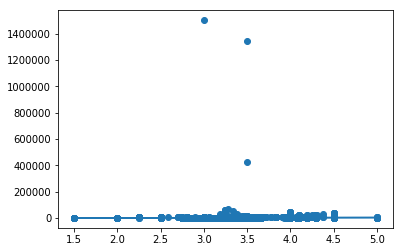

In [15]:
regression(CPIA_all['value'],GDP_CPIA_all['value'],'CPIA','GDP')